# Explore Data

Project : Predicting Monthly Electricity Consumption 

## Table of Contents
- [Explore Electricity Data](#eia)
    - [Compare Actual Electricity Consumption to EIA Short Term Energy Outlook](#compare)
- [Explore Population Data](#pop) 
- [Heating and Cooling days by State](#heatcool)
- [Unempolyment by State](#ur)
- [Personal Income by State](#income)
- [Consumer Price Index US](#cpi)
- [GDP per state (GSP)](#gsp)
- [Regional group](#group)

Explore variation by state and time. Relationship with time is important for predicting future data.


In [13]:
# import the library
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold

from IPython.display import display
import matplotlib.dates as mdates
import matplotlib
from matplotlib import cm
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'
mfolder = 'E:/Users/Fern/energy_data/'

In [7]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia':'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [19]:
from scipy.cluster import hierarchy as hc

def make_dendo(df):
    '''create a dendogram showing redundant features'''
    corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))
    
    for i in range(corr.shape[0]):
        corr[i,i] = 1
    
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr, method='average')
    fig = plt.figure(figsize=(10,8))
    dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=18)
    plt.show()

In [14]:
#load data without dropna()
combine = pd.read_csv(cleanfolder+'combine.csv')

# set State and Regions columns as category 
combine['State'] = combine['State'].astype('category')
combine['Regions'] = combine['Regions'].astype('category')

# obtain state latitude and longitude
state_location = pd.read_html('https://inkplant.com/code/state-latitudes-longitudes')[0]
state_location['State'] = state_location['State'].replace(to_replace=us_state_abbrev)

combine = combine.merge(state_location,on='State')
combine['Year-Month'] = pd.to_datetime(combine['Year-Month'])
combine = combine.set_index('Year-Month')

In [73]:
# calculate consumption per capita
combine['Sale_RES_per_cap'] = combine['Sale_RES']/combine['Pop']
combine['Sale_COM_per_cap'] = combine['Sale_COM']/combine['Pop']
combine['Sale_IND_per_cap'] = combine['Sale_IND']/combine['Pop']
combine['Cus_RES_per_cap'] = combine['Cus_RES']/combine['Pop']
combine['Cus_COM_per_cap'] = combine['Cus_COM']/combine['Pop']
combine['Cus_IND_per_cap'] = combine['Cus_IND']/combine['Pop']
combine['Income_per_cap'] = combine['Income']/combine['Pop']
combine['GSP_per_cap'] = combine['GSP']/combine['Pop']

In [74]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Density', 'Sale_ALL_no_OTH', 'Latitude', 'Longitude',
       'Sale_RES_per_cap', 'Sale_COM_per_cap', 'Sale_IND_per_cap',
       'Cus_RES_per_cap', 'Cus_COM_per_cap', 'Cus_IND_per_cap',
       'Income_per_cap', 'GSP_per_cap'],
      dtype='object')

# Explore Electricity Data<a id='eia'></a>

Explore relationship between the sale and revenue for each sector.

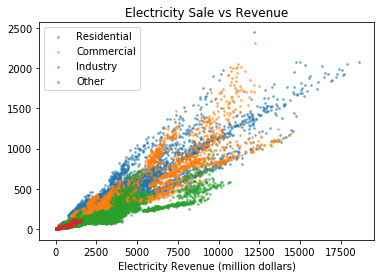

In [39]:
sale_cols = ['Sale_RES', 'Sale_COM', 'Sale_IND','Sale_OTH']
rev_cols = ['Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH']

for sale_col, rev_col in zip(sale_cols,rev_cols):
    plt.scatter(x=raw[sale_col],y=raw[rev_col],label=sale_col[-4:],alpha=0.5,s=3)

plt.title('Electricity Sale vs Revenue')
plt.xlabel('Electricity Sale (million kilowatthours)')
plt.xlabel('Electricity Revenue (million dollars)')
plt.legend(['Residential','Commercial','Industry','Other'])


Since revenue follow a linear relationship with consumption with slope as retail price. Being able to predict the consumption also means predicting the revenue.  

In [40]:
# drop revenue columns from the feature 
raw = raw.drop(rev_cols,axis=1)

In [41]:
# distribution among each sector
percent = raw[sale_cols].sum(axis=0)
percent = percent/percent.sum()

Text(0.5, 1.0, 'Electricity Consumption in Each Sector')

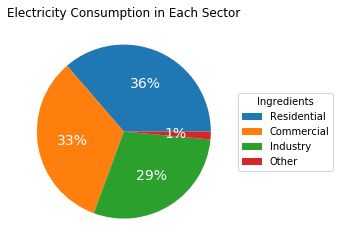

In [42]:
plt.pie(percent,autopct= '%.0f%%', textprops=dict(size='14',color="w"))
plt.legend( ['Residential','Commercial','Industry','Other'],
          title="Ingredients",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Electricity Consumption in Each Sector')

In [200]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Sale_ALL_no_OTH', 'Density', 'Latitude', 'Longitude',
       'Sale_RES_per_cap', 'Sale_COM_per_cap', 'Sale_IND_per_cap',
       'Cus_RES_per_cap', 'Cus_COM_per_cap', 'Cus_IND_per_cap',
       'Income_per_cap', 'GSP_per_cap'],
      dtype='object')

Consumption vs time for the states with most and least consumption.

In [47]:
col = 'Sale_RES'
# identify states with the most and the least consumption
data = combine.loc['2018-01-01'].sort_values(col)
#drop AK and HI data 
data = data[~data['State'].isin(['AK','HI'])]
select_state = np.concatenate((data['State'].values[:3],data['State'].values[-3:]))
data = combine[combine['State'].isin(select_state)]

Text(0.5, 0.98, 'Monthly Consumption by State')

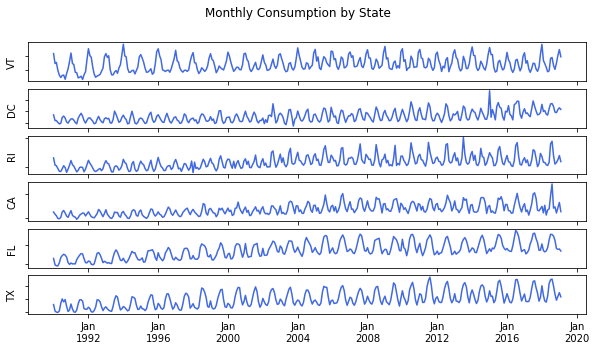

In [49]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(6,1,figsize=(10, 5),sharex=True)

for i, state in enumerate(select_state):
    temp = data[data['State']==state]
    ax[i].plot(temp[col],c='royalblue')
    ax[i].axes.set_ylabel(state)
    ax[i].axes.set_yticklabels([])

ax[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
fig.suptitle('Monthly Consumption by State')

Consumption for California 

Text(0.5, 0.98, 'Monthly Consumption by for California')

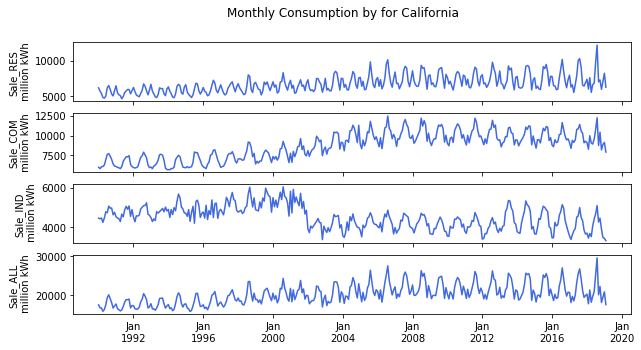

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sale_cols = ['Sale_RES', 'Sale_COM', 'Sale_IND','Sale_ALL']
state = 'CA'
data = combine[combine['State']==state]

fig, ax = plt.subplots(4,1,figsize=(10, 5),sharex=True)

for i,col in enumerate(sale_cols):
    ax[i].plot(data[col],c='royalblue')
    ax[i].axes.set_ylabel(col + '\n million kWh')
    
ax[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
fig.suptitle('Monthly Consumption by for California')

There is a seasonal pattern in electricity consumption. 

Since all models consider state population as the most important feature, it is worth looking at the consumption per population for each state.

In [53]:
def get_color(series,cmap=cm.Blues):
    ''' obtain hex color map for each value'''
    vmin = series.min()
    vmax = series.max()
    #normalize item number values to colormap
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    #colormap values = viridis, jet, spectral
    state_colors = [cmap(norm(value)) for value in series.values]
    state_colors = [str(cm.colors.to_hex(color)) for color in state_colors]
    return state_colors

In [64]:
# select data in 2018
data = combine[combine['Year']==2018]
# group by State and obtain average each columns except for the Regions
data = data[['State','Regions','Latitude','Sale_RES_per_cap',
             'Sale_COM_per_cap','Sale_IND_per_cap'
            ]].groupby('State',as_index=False
                      ).agg({'Latitude':'mean','Sale_RES_per_cap':'mean',
             'Sale_COM_per_cap':'mean','Sale_IND_per_cap':'mean',
                             'Regions':'last'
    
})

In [65]:
# another df groupby 'Region'
data2 = combine[combine['Year']==2018].copy()
data2 = data2[['Regions','Latitude','Sale_IND_per_cap']].groupby('Regions',as_index=False).mean()
# assigned industrial color map
ind_colors = get_color(data2['Sale_IND_per_cap'],cm.Paired)
data2['IND_color'] = ind_colors
# merge with the first data df 
data = data.merge(data2.drop('Sale_IND_per_cap',axis=1),on='Regions')

In [66]:
# sort data 
data = data.sort_values(['Latitude_y','Latitude_x'],ascending=True)

In [67]:
# get color map
res_colors = get_color(data['Sale_RES_per_cap'])
ind_colors = data['IND_color'].values
com_colors = get_color(data['Sale_COM_per_cap'],cm.YlGn)

In [68]:
data.Regions.unique()

array(['West South Central ', 'East South Central ', 'South Atlantic ', 'Mountain ', 'Middle Atlantic ',
       'Pacific Noncontiguous ', 'East North Central ', 'West North Central ', 'Pacific Contiguous ',
       'New England '], dtype=object)

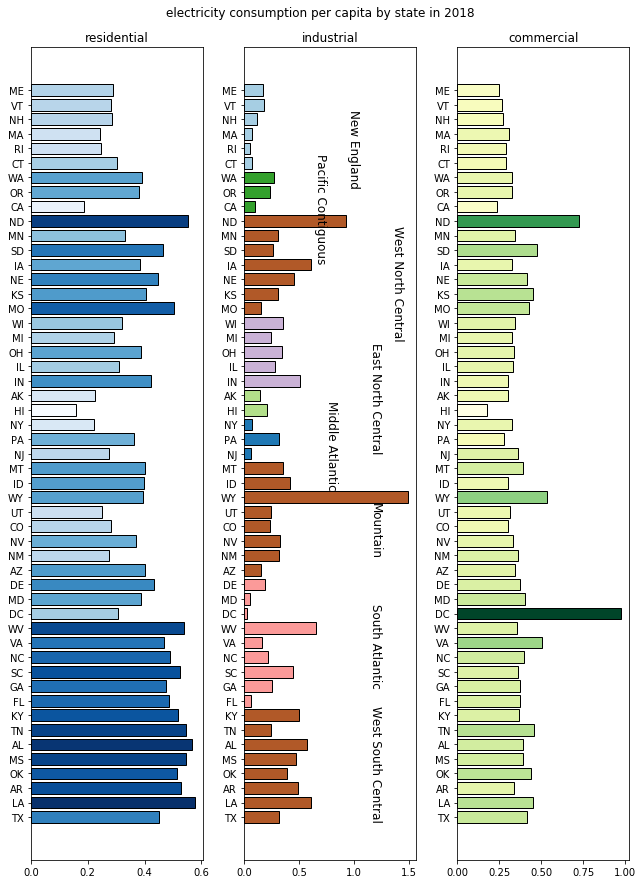

In [69]:
fig, ax = plt.subplots(1,3, figsize=(9,12))
fig.suptitle('electricity consumption per capita by state in 2018',y=1.02)
ax[0].barh(data['State'],data['Sale_RES_per_cap'],color=res_colors,edgecolor='black')
ax[0].set_xlabel('residential',size=12)
ax[0].xaxis.set_label_coords(0.5, 1.02)

ax[2].barh(data['State'],data['Sale_COM_per_cap'],color=com_colors,edgecolor='black')
ax[2].set_xlabel('commercial',size=12)
ax[2].xaxis.set_label_coords(0.5, 1.02)

ax[1].barh(data['State'],data['Sale_IND_per_cap'],color=ind_colors,edgecolor='black')
ax[1].set_xlabel('industrial',size=12)
ax[1].xaxis.set_label_coords(0.5, 1.02)

ax[1].text(1.2, 7, 'West South Central',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(1.2, 14, 'South Atlantic',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(1.2, 21, 'Mountain',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(0.8, 28, 'Middle Atlantic',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(1.2, 32, 'East North Central',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(1.4, 40, 'West North Central',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(0.7, 45, 'Pacific Contiguous',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
ax[1].text(1.0, 48, 'New England',
         {'color': 'k', 'fontsize': 12, 'ha': 'center','rotation':'-90'})
plt.tight_layout()

Average electricity consumption per capita by state in 2018. The vertical axis is first group by the state regional group, then sort by the state latitude. The left, middle and right plots are consumption for residential, industrial and commercial sectors accordingly. For the residential consumption, one might expect that the northern states with a longer winter would require more electricity for heating would use more electricity; however the southern states turn out to use more electricity, which means the number of days that requires air conditioning usage (number of cooling days) and regional information would be important features in the model. For the industrial sector, the consumption can be grouped based on regions, thus regional information is an also important feature. For the commercial sector, except for DC, the consumption is pretty uniform, thus regional information is not important features.

## Compare Actual Electricity Consumption to EIA Short Term Energy Outlook<a id='compare'></a>

In [109]:
steo = pd.read_csv(cleanfolder+'steo.csv')
steo['Regions'] = steo['Regions'].astype('category')
steo['Year-Month'] = pd.to_datetime(steo['Year-Month'])
steo.head()

,Regions,Year-Month,Sale_COM,Sale_IND,Sale_RES,Sale_All,Year,Month,Sale_ALL_no_OTH
0,East North Central,2015-01-01,15841.0,16337.0,19282.0,51522.0,2015,1,51460.0
1,East South Central,2015-01-01,7564.0,8649.0,12245.0,28458.0,2015,1,28458.0
2,Middle Atlantic,2015-01-01,13454.0,5952.0,13299.0,33077.0,2015,1,32705.0
3,Mountain,2015-01-01,7502.0,6789.0,8246.0,22537.0,2015,1,22537.0
4,New England,2015-01-01,4526.0,1488.0,4774.0,10850.0,2015,1,10788.0


In [145]:
def compare_steo(col):
    '''plot steo and actual consumption for a particular sector by region 
       return the total r2_score  
    '''
    compare = steo[['Regions','Year-Month',col]]
    data = combine.reset_index()[['Regions','Year-Month',col]].groupby(['Regions','Year-Month'],as_index=False).sum()
    # merge actual consumption and prediction 
    compare = compare.merge(data, on =['Regions','Year-Month'],suffixes = ('_steo', '_real'))
    r2 = r2_score(compare[col+'_real'].values,compare[col+'_steo'].values)
    print(f'R2 score for {col} is ', r2)
    compare.set_index('Year-Month',inplace=True)
    
    fig, ax = plt.subplots(compare['Regions'].nunique(),1,figsize=(10,11),sharex=True)

    for i, region in enumerate(compare['Regions'].unique()):
        temp = compare[compare['Regions']==region]
        ax[i].plot(temp[col+'_steo'],c='orange',alpha=0.5)
        ax[i].plot(temp[col+'_real'],c='royalblue',alpha=0.5)
        ax[i].legend(['real','steo'], loc='upper right')
        ax[i].axes.set_ylabel(region.replace(' ','\n'))
        ax[i].axes.set_yticklabels([])

    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
    fig.suptitle('Compare Monthly STEO by Region for'+ col)
    return r2

R2 score for Sale_RES is  0.9999988076931441
R2 score for Sale_IND is  0.9999967091900294
R2 score for Sale_COM is  0.9999984127134681
R2 score for Sale_ALL_no_OTH is  0.9999993436642667


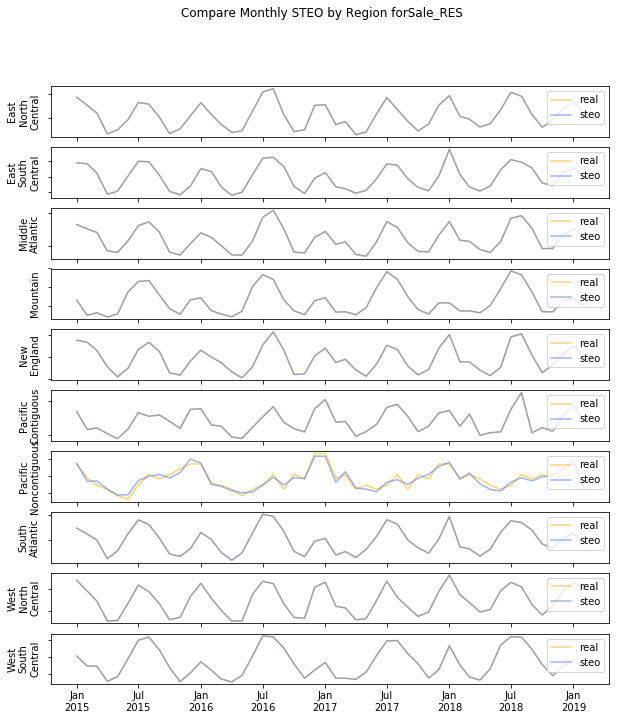

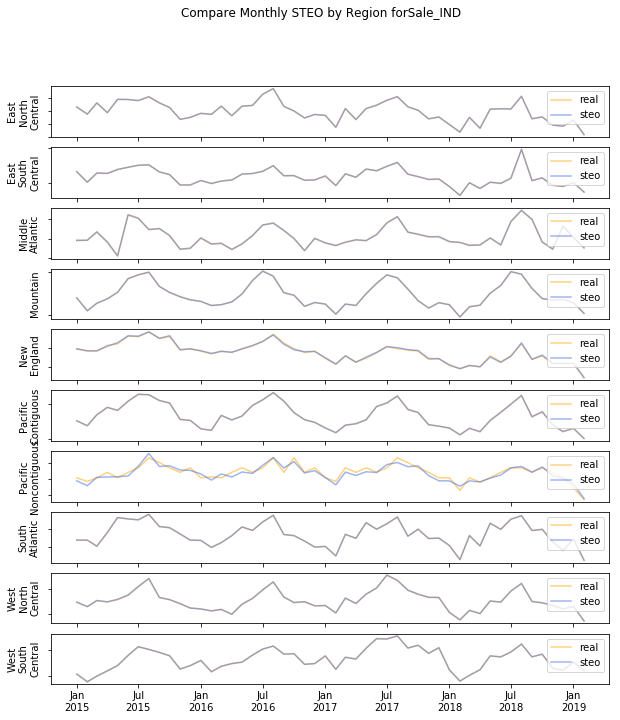

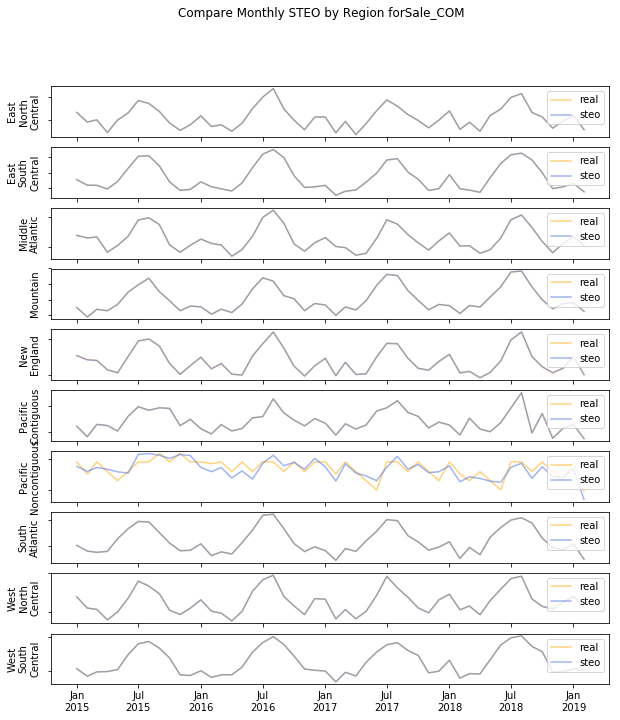

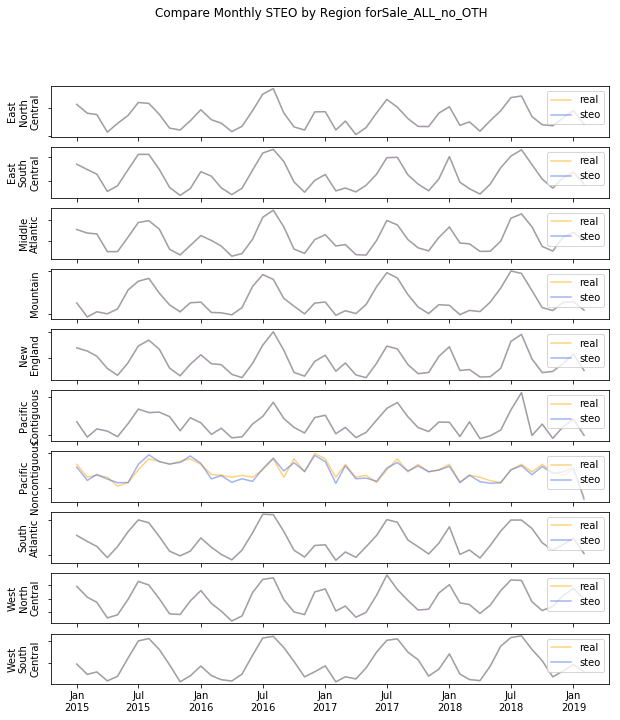

In [148]:
cols = ['Sale_RES','Sale_IND','Sale_COM','Sale_ALL_no_OTH']
r2all = []

for col in cols: 
    r2 = compare_steo(col)
    r2all.append(r2)


<BarContainer object of 4 artists>

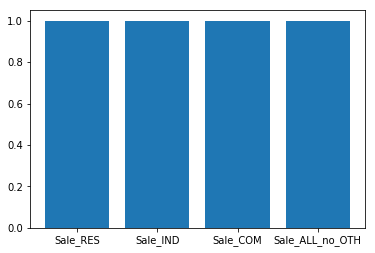

In [149]:
plt.bar(x=cols,height=r2all)

- EIA achieves R2 0.99 in most prediction. The worse prediction is in predicting AK and HI (Pacific Noncontinuous) 
- RES, IND, COM all has seasonal pattern; thus have to feed this kind of features in the model.

# Explore Population Data<a id='pop'></a>

In [70]:
# load state location json
with open('statemap.json','r') as fp:
    statemap = json.load(fp)
    
def draw_state(subplot, name,cfill='lightblue',cedge='turquoise',alphafill=0.5,alphaedge=1):
    """   
    Automatically draws a filled shape representing the state in
    subplot (ax object).  
    name is abbreviation of the state.
    cfill is the fill color
    cedge is the edge color
    alphafill is the fill transparency
    alphaedge is the edge transparency
    """
    polygons = statemap[name]
    for polygon in polygons:
        xs, ys = zip(*polygon)
        subplot.fill(xs, ys, c=cfill,alpha=alphafill)
        subplot.plot(xs, ys, c=cedge,alpha=alphaedge)

Population in 2018 by State

In [71]:
data = combine[['State','Year','Pop']].groupby(['Year','State'],as_index=False).max()
data = data[data['Year']==2018]
data['color'] = get_color(data['Pop'])

Text(0.5, 1.0, 'Population by State in 2018')

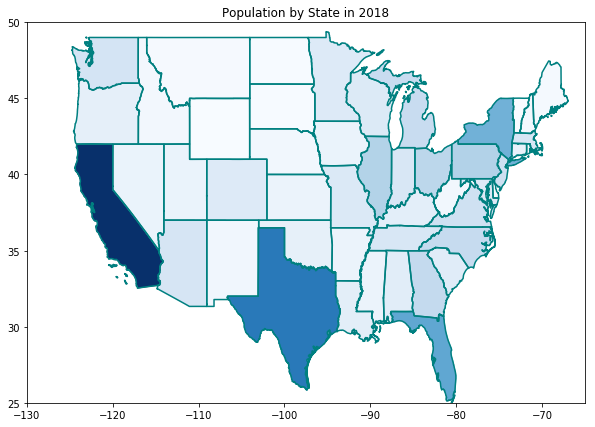

In [72]:
_,ax = plt.subplots(figsize=(10,7))

for state in data['State'].values:
    fillcolor = data[data['State']==state]['color'].values[0]
    draw_state(ax, state,cfill=fillcolor,cedge='teal',alphafill=1,alphaedge=1)

plt.xlim([-130,-65])
plt.ylim([25,50])
plt.title('Population by State in 2018')

CA, TX, FL and NY are the most populated states 

Text(0.5, 0, 'State')

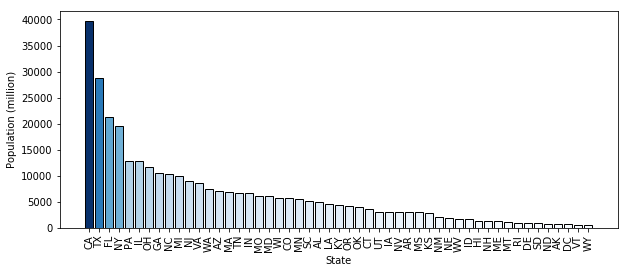

In [73]:
data = data.sort_values('Pop',ascending=False)
_ = plt.figure(figsize=(10,4))
plt.bar(x=data['State'],height=data['Pop'],color=data['color'],edgecolor='black')
_= plt.xticks(rotation=90)
plt.ylabel('Population (million)')
plt.xlabel('State')

Population density 

In [78]:
data = combine[['State','Year','Density']].groupby(['Year','State'],as_index=False).max()
data = data[data['Year']==2018]
# drop DC because the density is much higher than other
data = data[data['State']!='DC']
data['color'] = get_color(data['Density'])

Text(0.5, 1.0, 'Population Density by State in 2018 (Without DC)')

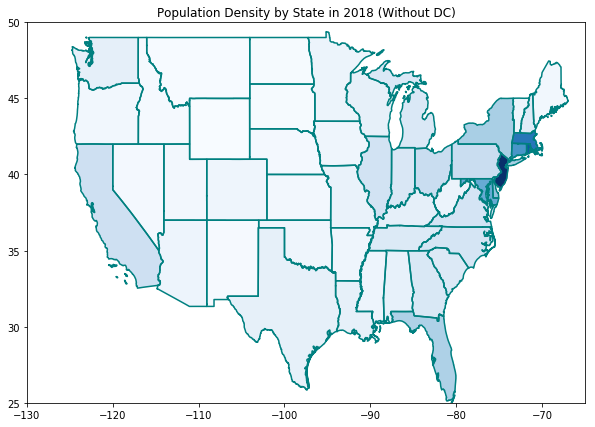

In [79]:
_,ax = plt.subplots(figsize=(10,7))

for state in data['State'].values:
    fillcolor = data[data['State']==state]['color'].values[0]
    draw_state(ax, state,cfill=fillcolor,cedge='teal',alphafill=1,alphaedge=1)

plt.xlim([-130,-65])
plt.ylim([25,50])
plt.title('Population Density by State in 2018 (Without DC)')

Text(0.5, 0, 'State')

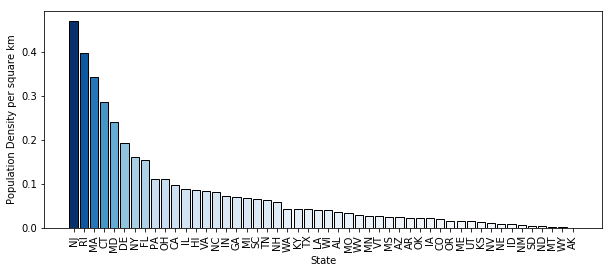

In [80]:
data = data.sort_values('Density',ascending=False)
_ = plt.figure(figsize=(10,4))
plt.bar(x=data['State'],height=data['Density'],color=data['color'],edgecolor='black')
_= plt.xticks(rotation=90)
plt.ylabel('Population Density per square km')
plt.xlabel('State')
plt.title('Population Density by State in 2018 (Without DC)')

In [33]:
data.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Density', 'Sale_ALL_no_OTH', 'Latitude',
       'Longitude'],
      dtype='object')

Text(0.5, 1.0, 'Population in 2018')

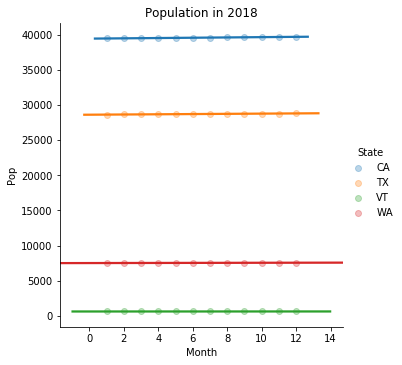

In [44]:
states = ['CA','TX','VT','WA']
year ='2018'
data = combine[combine['State'].isin(states)]
data = data.loc[year]

sns.lmplot(data=data,x='Month',y='Pop',hue='State', scatter_kws={'alpha':0.3})
plt.title('Population in ' + year)

# Heating and Cooling days by State<a id='heatcool'></a>

In [90]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Sale_ALL_no_OTH'],
      dtype='object')

Maximum cooling and heating degree days in 2018

In [97]:
data = combine[['State','Year','Heating_deg_days','Cooling_deg_days']].groupby(['State','Year'],as_index=False).max().dropna()
data = data[data['Year']==2018]
#load state location data 
state_location = pd.read_csv('state_location.csv')
data = data.merge(state_location,on='State')

In [98]:
data.head()

,State,Year,Heating_deg_days,Cooling_deg_days,Latitude,Longitude
0,AL,2018,796.0,474.0,32.806671,-86.791130
1,AR,2018,921.0,511.0,34.969704,-92.373123
2,AZ,2018,475.0,717.0,33.729759,-111.431221
3,CA,2018,493.0,377.0,36.116203,-119.681564
4,CO,2018,1169.0,152.0,39.059811,-105.311104


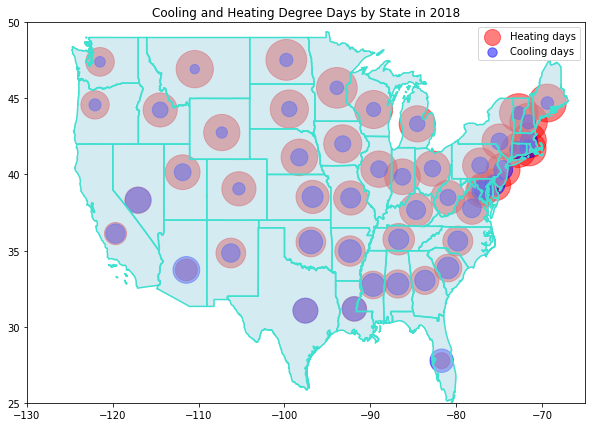

In [112]:
_,ax = plt.subplots(figsize=(10,7))

for state in data['State'].values:
    draw_state(ax, state)
    
plt.scatter(x=data['Longitude'],y=data['Latitude'],s=data['Heating_deg_days'],c='red',alpha=0.5,label='Heating day')
plt.scatter(x=data['Longitude'],y=data['Latitude'],s=data['Cooling_deg_days'],c='blue',alpha=0.5)

marker1 = plt.scatter([],[], s=data['Heating_deg_days'].min(),c='red',alpha=0.5)
marker2 = plt.scatter([],[], s=data['Cooling_deg_days'].min(),c='blue',alpha=0.5)
plt.legend(handles=[marker1,marker2],labels=['Heating days','Cooling days'])


plt.xlim([-130,-65])
plt.ylim([25,50])
_=plt.title('Cooling and Heating Degree Days by State in 2018')

For northern states, the numbers of heating days is larger than the number of cooling days for all states except FL. 

**Does the number of days change over the year?**
The number of heating and cooling days follow seasonal pattern. The total days/year should be similar, but global warming is changing the number of cooling and heating days / year. Check if this is true. Sum the number of days of each state for each year and observe the trend 

In [7]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Area', 'Sale_ALL_no_OTH'],
      dtype='object')

In [147]:
data = combine[['Regions','State','Year','Month','Heating_deg_days','Cooling_deg_days']].groupby([
    'Year','State'],as_index=False).agg({'Regions':'last','Heating_deg_days':'sum',
                                         'Cooling_deg_days':'sum'}).dropna()
#data = data.groupby(['Regions','Year'],as_index=False).mean()

In [148]:
data.columns

Index(['Year', 'State', 'Regions', 'Heating_deg_days', 'Cooling_deg_days'], dtype='object')

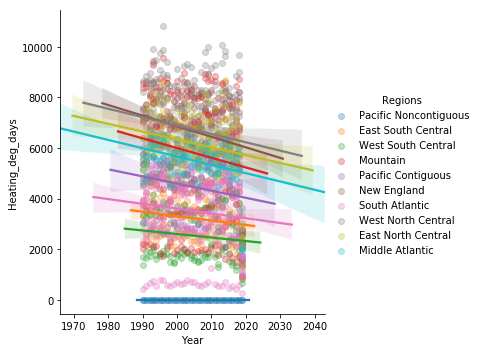

In [152]:
sns.lmplot(data=data,x='Year',y='Heating_deg_days',hue='Regions', scatter_kws={'alpha':0.3})

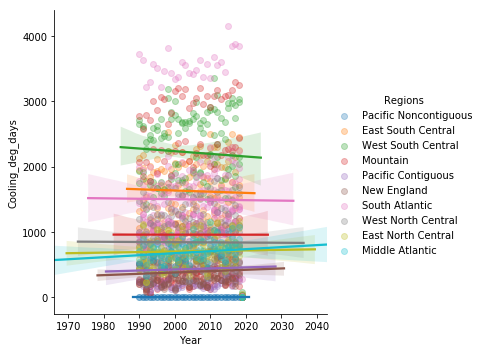

In [153]:
sns.lmplot(data=data,x='Year',y='Cooling_deg_days',hue='Regions',  scatter_kws={'alpha':0.3})

The heating days seem to have a decreasing trend and cooling deg days have an increasing trend for some region.

**Is it possible to predict the future heating and cooling day by state?** 
Let's look at the trend for some northern and southern states: 'WA', 'FL', 'CA', 'TX' 

In [135]:
data = combine[['Year','Month','State', 'Heating_deg_days','Cooling_deg_days']].dropna()
states = ['WA', 'FL', 'CA', 'TX']
data = data[data['State'].isin(states)]

In [136]:
data.columns

Index(['Year', 'Month', 'State', 'Heating_deg_days', 'Cooling_deg_days'], dtype='object')

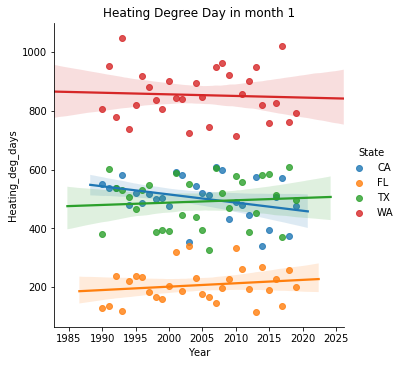

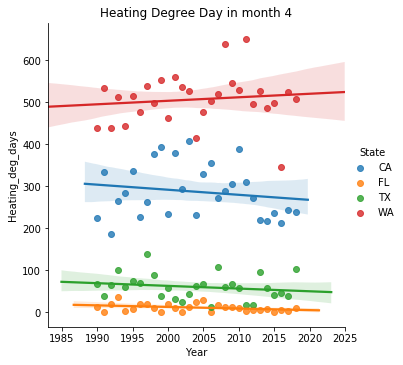

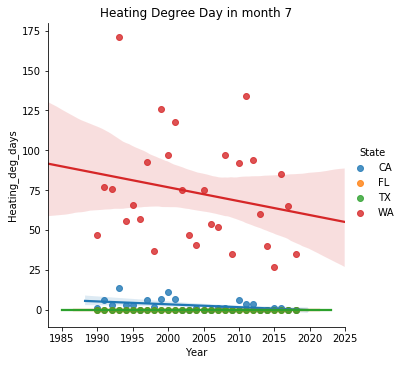

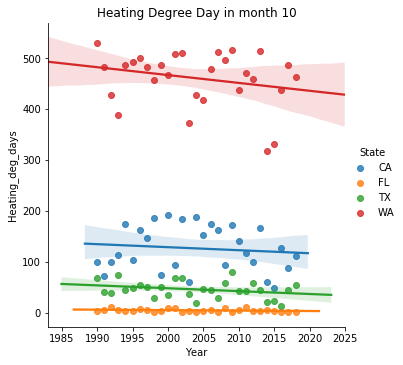

In [145]:
months = [1,4,7,10]

#fig, ax = plt.subplots(2,2,figsize=(10,10))

for i, month in enumerate(months):
    temp = data[data['Month']== month]
    sns.lmplot(data=temp,x='Year',y='Heating_deg_days',hue='State')
    plt.title('Heating Degree Day in month '+str(month))

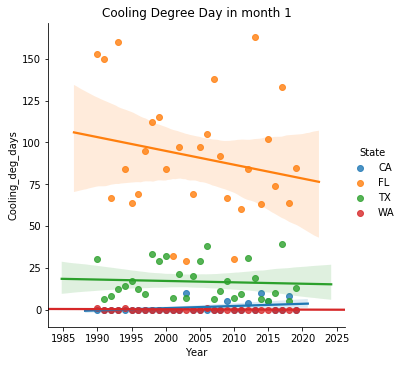

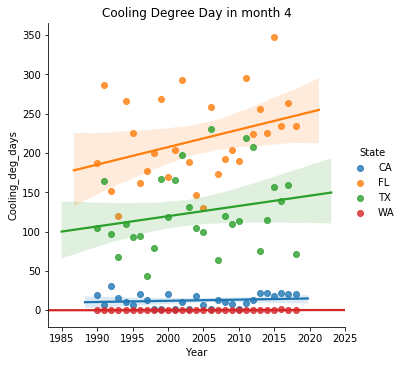

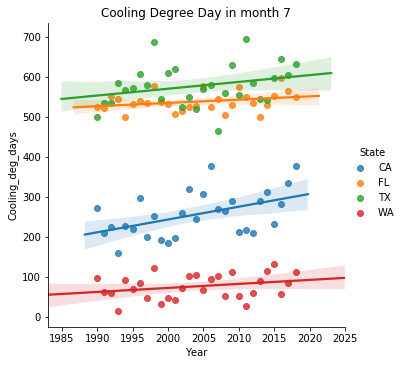

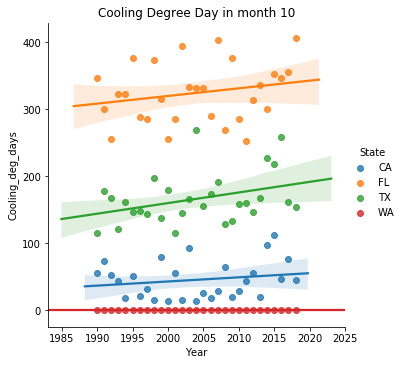

In [146]:
months = [1,4,7,10]

#fig, ax = plt.subplots(2,2,figsize=(10,10))

for i, month in enumerate(months):
    temp = data[data['Month']== month]
    sns.lmplot(data=temp,x='Year',y='Cooling_deg_days',hue='State')
    plt.title('Cooling Degree Day in month '+str(month))

- Large variation among the states in the same regional group means that for estimating the heating and cooling degree days, the data cannot be fitted together.
- When looking at the data by state, heating and cooling degree days have high variance, unless the values are close to zero. The slope are not the same for each states, and thus have to be fitted by state. 

Text(0.5, 1.0, 'Cooling Degree Day in month 7')

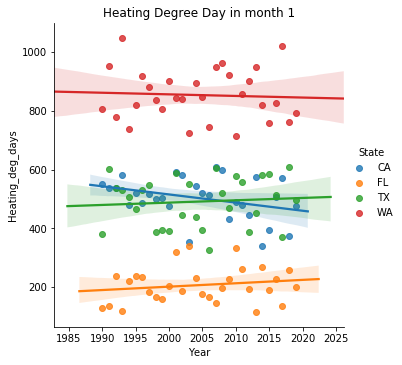

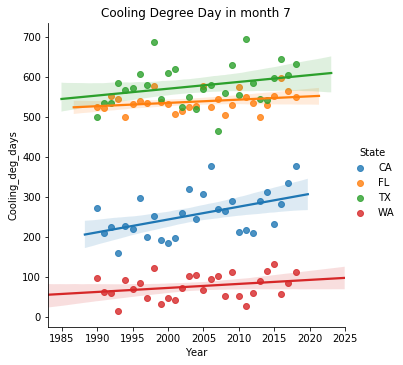

In [29]:
states = ['CA','FL','TX','WA']
months = [1,7]

data = combine[combine['State'].isin(states)]

sns.lmplot(data=data[data['Month']==months[0]],
                  x='Year',y='Heating_deg_days',hue='State')
plt.title('Heating Degree Day in month '+str(month[0]))

sns.lmplot(data=data[data['Month']==months[1]],
                  x='Year',y='Cooling_deg_days',hue='State')
plt.title('Cooling Degree Day in month '+str(month[1]))

# Personal Income by State<a id='income'>
    
Income is the total income. Here, I look at the income per capita.

In [157]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Sale_ALL_no_OTH', 'Density', 'Latitude', 'Longitude',
       'Sale_RES_per_cap', 'Sale_COM_per_cap', 'Sale_IND_per_cap',
       'Cus_RES_per_cap', 'Cus_COM_per_cap', 'Cus_IND_per_cap',
       'Income_per_cap', 'GSP_per_cap'],
      dtype='object')

In [174]:
data = combine[['State','Year','Income']].groupby(['Year','State'],as_index=False).mean()
data = data[data['Year']==2018]

data['color'] = get_color(data['Income'],cm.Greens)

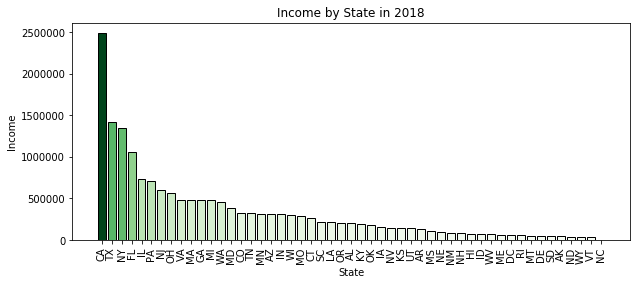

In [175]:
data = data.sort_values('Income',ascending=False)
_ = plt.figure(figsize=(10,4))
plt.bar(x=data['State'],height=data['Income'],color=data['color'],edgecolor='black')
_= plt.xticks(rotation=90)
plt.ylabel('Income')
plt.xlabel('State')
_ = plt.title('Income by State in 2018')

In [178]:
data = combine[['State','Year','Income_per_cap']].groupby(['Year','State'],as_index=False).mean()
data = data[data['Year']==2018]
data['color'] = get_color(data['Income_per_cap'])

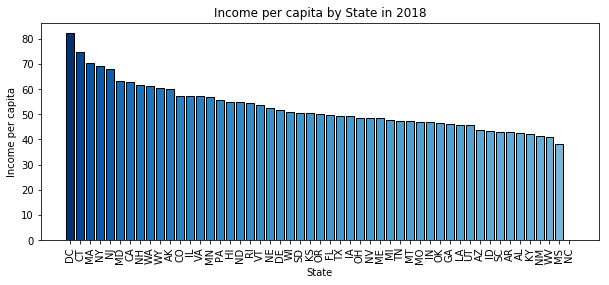

In [179]:
data = data.sort_values('Income_per_cap',ascending=False)
_ = plt.figure(figsize=(10,4))
plt.bar(x=data['State'],height=data['Income_per_cap'],color=data['color'],edgecolor='black')
_= plt.xticks(rotation=90)
plt.ylabel('Income per capita')
plt.xlabel('State')
_ = plt.title('Income per capita by State in 2018')

Text(0.5, 1.0, 'Income per capita by State in 2018')

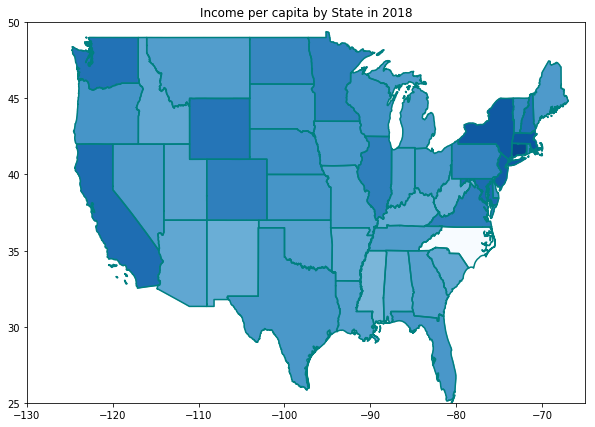

In [180]:
_,ax = plt.subplots(figsize=(10,7))

for state in data['State'].values:
    fillcolor = data[data['State']==state]['color'].values[0]
    draw_state(ax, state,cfill=fillcolor,cedge='teal',alphafill=1,alphaedge=1)

plt.xlim([-130,-65])
plt.ylim([25,50])
plt.title('Income per capita by State in 2018')

Income growth by state

In [169]:
data = combine[['Year','Month','State', 'Income']].dropna()
# look at the state with the most and the smallest income 
states = ['CA', 'TX', 'NY', 'ND', 'WY','VT']
data = data[data['State'].isin(states)].reset_index()

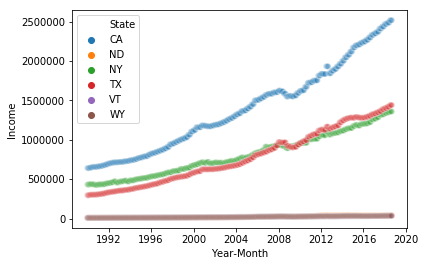

In [173]:
sns.scatterplot(data=data,x='Year-Month',y='Income',hue='State', alpha=0.3)

Text(0.5, 1.0, 'Personal Income in 2018')

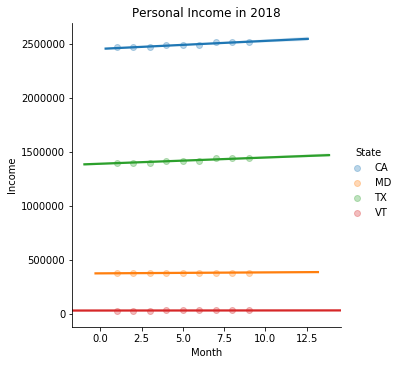

In [50]:
states = ['CA','TX','MD','VT']
year ='2018'
data = combine[combine['State'].isin(states)]
data = data.loc[year]

sns.lmplot(data=data,x='Month',y='Income',hue='State', scatter_kws={'alpha':0.3})
plt.title('Personal Income in ' + year)

# GDP per state (GSP)<a id='gsp'>

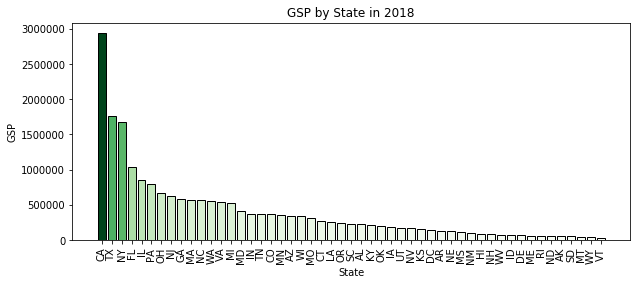

In [186]:
data = combine[['State','Year','GSP']].groupby(['Year','State'],as_index=False).mean()
data = data[data['Year']==2018]
data['color'] = get_color(data['GSP'],cm.Greens)

data = data.sort_values('GSP',ascending=False)
_ = plt.figure(figsize=(10,4))
plt.bar(x=data['State'],height=data['GSP'],color=data['color'],edgecolor='black')
_= plt.xticks(rotation=90)
plt.ylabel('GSP')
plt.xlabel('State')
_ = plt.title('GSP by State in 2018')

Text(0.5, 1.0, 'GSP by State in 2018')

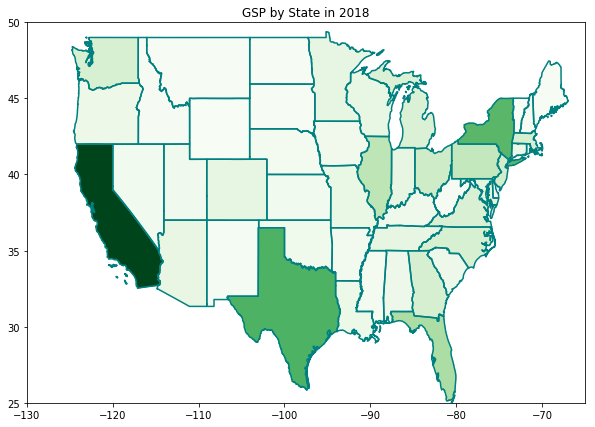

In [187]:
_,ax = plt.subplots(figsize=(10,7))

for state in data['State'].values:
    fillcolor = data[data['State']==state]['color'].values[0]
    draw_state(ax, state,cfill=fillcolor,cedge='teal',alphafill=1,alphaedge=1)

plt.xlim([-130,-65])
plt.ylim([25,50])
plt.title('GSP by State in 2018')

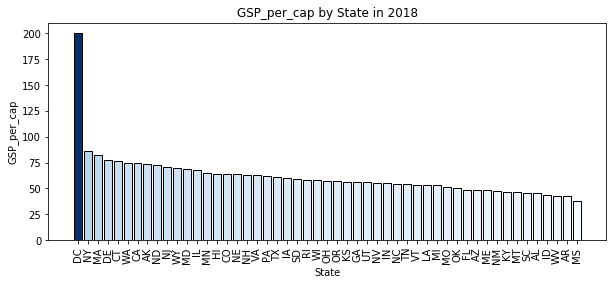

In [185]:
data = combine[['State','Year','GSP_per_cap']].groupby(['Year','State'],as_index=False).mean()
data = data[data['Year']==2018]
data['color'] = get_color(data['GSP_per_cap'])

data = data.sort_values('GSP_per_cap',ascending=False)
_ = plt.figure(figsize=(10,4))
plt.bar(x=data['State'],height=data['GSP_per_cap'],color=data['color'],edgecolor='black')
_= plt.xticks(rotation=90)
plt.ylabel('GSP_per_cap')
plt.xlabel('State')
_ = plt.title('GSP_per_cap by State in 2018')

Look at GSP over time for CA, TX, NY and MT,WY, VT (three most and three least GSP) 

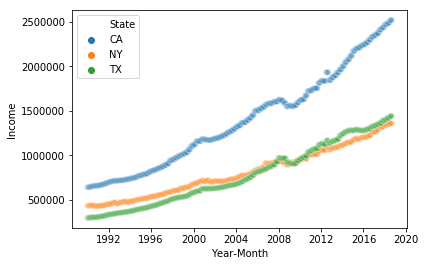

In [189]:
data = combine[['Year','Month','State', 'Income']].dropna()
# look at the state with the most and the smallest income 
states = ['CA', 'TX', 'NY']
data = data[data['State'].isin(states)].reset_index()

sns.scatterplot(data=data,x='Year-Month',y='Income',hue='State', alpha=0.3)

(736330.0, 736938.0)

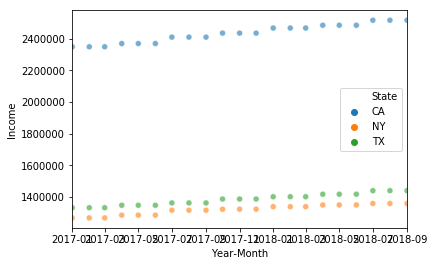

In [197]:
data = combine[['Year','Month','State', 'Income']].dropna()
data = data.loc['2017':'2018']
# look at the state with the most and the smallest income 
states = ['CA', 'TX', 'NY']
data = data[data['State'].isin(states)].reset_index()

sns.scatterplot(data=data,x='Year-Month',y='Income',hue='State', alpha=0.6)
plt.xlim(data['Year-Month'].min(),data['Year-Month'].max())

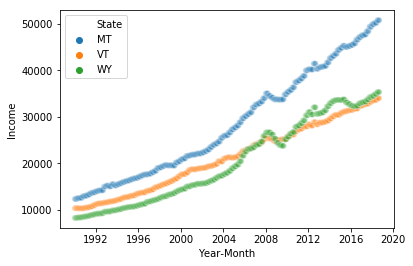

In [191]:
data = combine[['Year','Month','State', 'Income']].dropna()
# look at the state with the most and the smallest income 
states = ['MT','WY', 'VT']
data = data[data['State'].isin(states)].reset_index()

sns.scatterplot(data=data,x='Year-Month',y='Income',hue='State', alpha=0.3)

(736330.0, 736938.0)

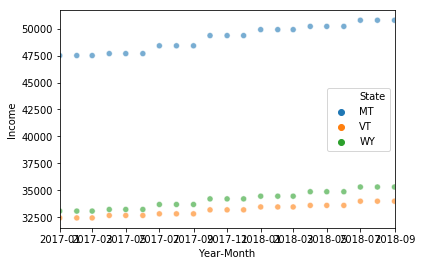

In [199]:
data = combine[['Year','Month','State', 'Income']].dropna()
data = data.loc['2017':'2018']
# look at the state with the most and the smallest income 
states = ['MT','WY', 'VT']
data = data[data['State'].isin(states)].reset_index()

sns.scatterplot(data=data,x='Year-Month',y='Income',hue='State', alpha=0.6)
plt.xlim(data['Year-Month'].min(),data['Year-Month'].max())

Text(0.5, 1.0, 'GSP Income in 2018')

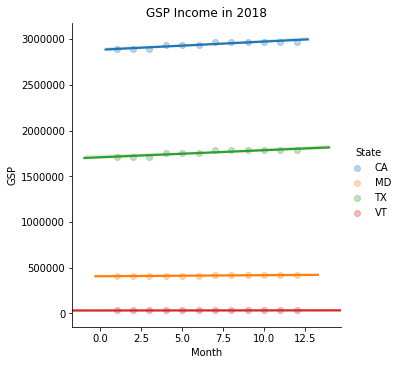

In [51]:
states = ['CA','TX','MD','VT']
year ='2018'
data = combine[combine['State'].isin(states)]
data = data.loc[year]

sns.lmplot(data=data,x='Month',y='GSP',hue='State', scatter_kws={'alpha':0.3})
plt.title('GSP Income in ' + year)

# Consumer Price Index US<a id='cpi'>
    
CPI is reported at a national level.

In [119]:
data = combine[['CPI']]

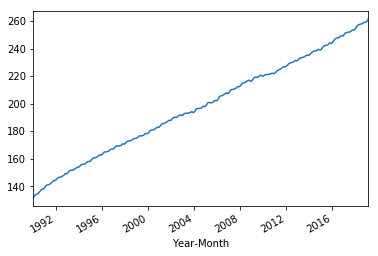

In [123]:
data['CPI'].plot()

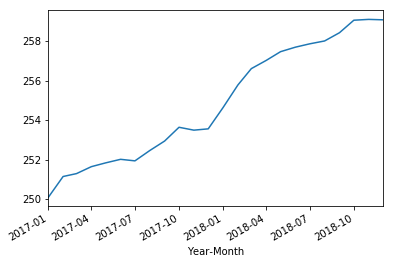

In [124]:
data['CPI'].loc['2017':'2018'].plot()

CPI follow a very noisy linear trend.

# Regional group<a id='group'>
    
Visualize regional group assigned by EIA. 

In [97]:
data = combine[['Regions','State']].drop_duplicates()
data['Regions'] = data['Regions'].astype('category')
data['color'] = get_color(data['Regions'].cat.codes,cm.Set1)

Text(0.5, 1.0, 'Regional Group According to EIA')

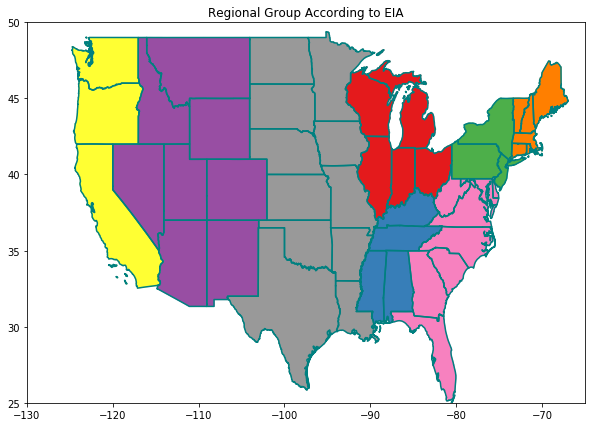

In [98]:
_,ax = plt.subplots(figsize=(10,7))

for state in data['State'].values:
    fillcolor = data[data['State']==state]['color'].values[0]
    draw_state(ax, state,cfill=fillcolor,cedge='teal',alphafill=1,alphaedge=1)

plt.xlim([-130,-65])
plt.ylim([25,50])
plt.title('Regional Group According to EIA')

# Data Relationship<a id='epa'></a>

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


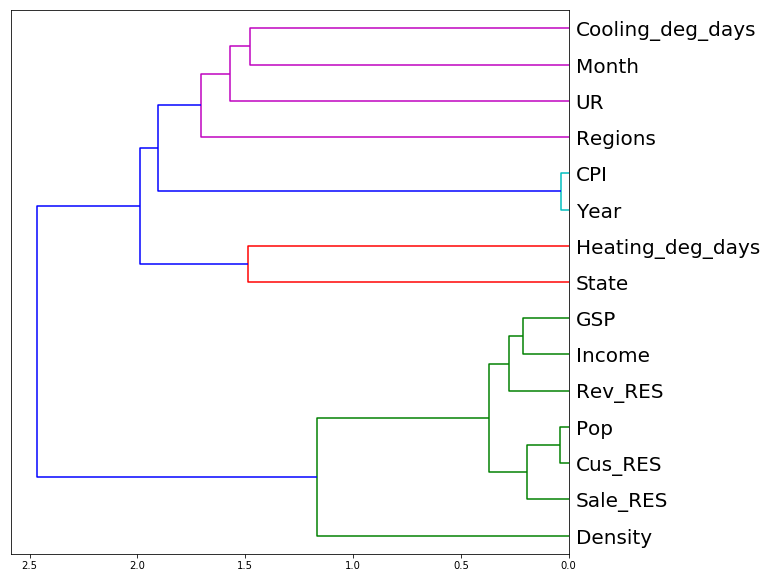

In [90]:
df = combine[['Year', 'Month', 'State', 'Sale_RES','Rev_RES','Cus_RES',
              'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP','CPI', 'Regions','Density']]

from scipy.cluster import hierarchy as hc

# Redundant Features
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
plt.show()

Population and number of customer are related. The GSP, income and Sale revenue are closely related. The number of heating and day is related to the location of the state. The revenue columns will not be fed into the model because of the direct relationship with the sale. Consider dropping one of the close relationship feature pairs: year and CPI, population and number of customer, and GSP and income.

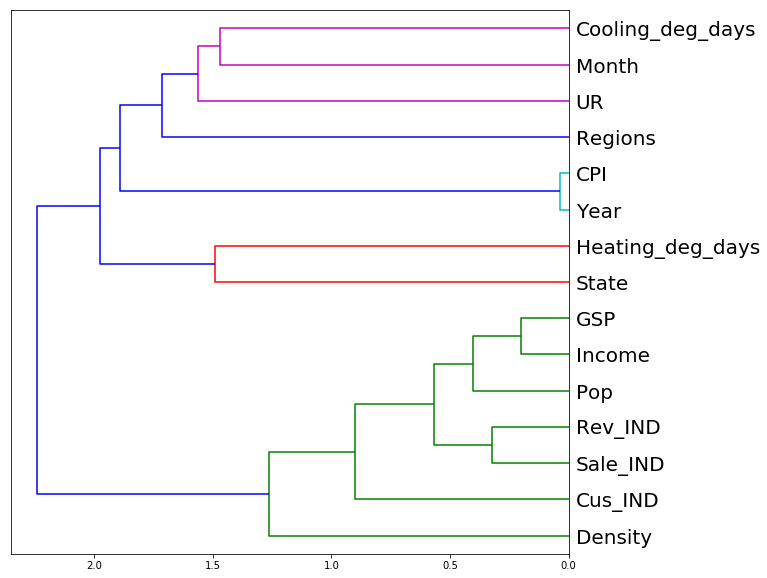

In [91]:
df = combine[['Year', 'Month', 'State', 'Sale_IND','Rev_IND','Cus_IND',
              'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP','CPI', 'Regions','Density']]

from scipy.cluster import hierarchy as hc

# Redundant Feature
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
plt.show()

Again the revenue data will not be fed into the model. Similarly, close relationship feature pairs: year and CPI, population and number of customer, and GSP and income might be dropped.

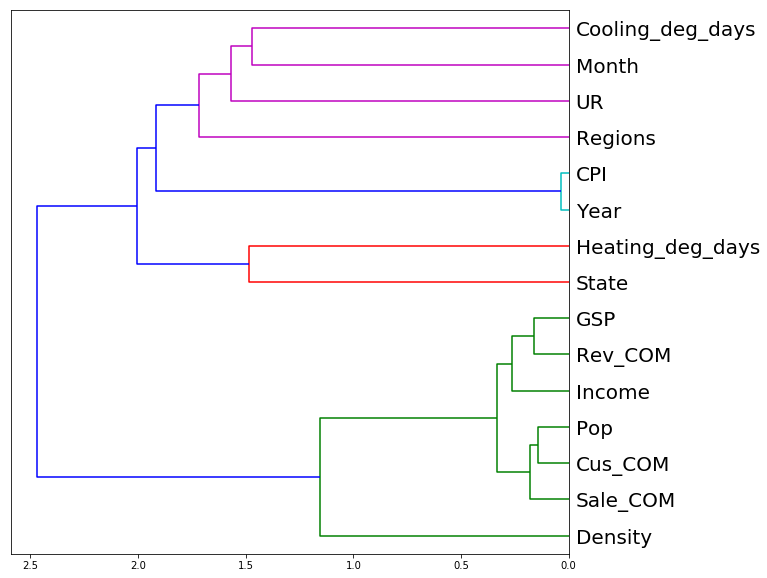

In [92]:
df = combine[['Year', 'Month', 'State', 'Sale_COM','Rev_COM','Cus_COM',
              'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP','CPI', 'Regions','Density']]

from scipy.cluster import hierarchy as hc

# Redundant Feature
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
plt.show()

Similarly, close relationship pairs were observed for the commercial consumption.

Relationship between features (all sectors). 

In [17]:
df = combine[['Year', 'Month', 'State', 'Sale_IND','Cus_IND','Sale_COM','Cus_COM','Sale_RES','Cus_RES',
              'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP','CPI', 'Regions','Density']]

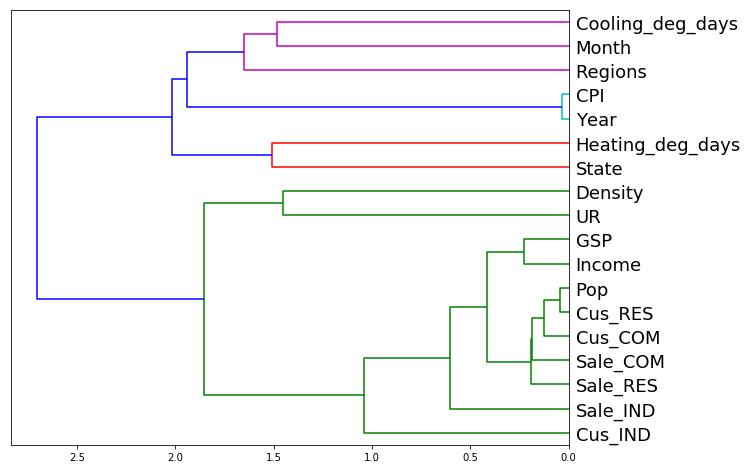

In [20]:
make_dendo(df)